In [33]:

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms

import time
import copy
import os

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import torchvision.transforms.functional as F
import timm
import pandas as pd

In [34]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ricardosalvatorelli1/paddydoctor")

print("Path to dataset files:", path)

Path to dataset files: /data/home/arunkumar12/.cache/kagglehub/datasets/ricardosalvatorelli1/paddydoctor/versions/1


In [35]:
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
data_dir = "/data/home/arunkumar12/dataset/"


In [36]:
# import os
# import shutil
# from pathlib import Path

# # Paths
# source_folder = '/data/home/arunkumar12/.cache/kagglehub/datasets/ricardosalvatorelli1/paddydoctor/versions/1/train_images'  # Replace with your source dataset folder
# destination_folder ="test_images"
# images_per_class = 50  # Number of images to copy per class

# # Create the destination folder
# os.makedirs(destination_folder, exist_ok=True)

# # Iterate through each class folder
# for class_name in os.listdir(source_folder):
#     class_path = os.path.join(source_folder, class_name)
#     if os.path.isdir(class_path):  # Check if it's a folder
#         # Create a corresponding folder in the destination
#         dest_class_folder = os.path.join(destination_folder, class_name)
#         os.makedirs(dest_class_folder, exist_ok=True)

#         # Get all image files in the class folder
#         images = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]

#         # Sort images to maintain order and select the first 50
#         selected_images = images[:images_per_class]

#         # Copy selected images to the destination folder
#         for img_name in selected_images:
#             src = os.path.join(class_path, img_name)
#             dest = os.path.join(dest_class_folder, img_name)
#             shutil.copy(src, dest)

# print(f"Test dataset created successfully in '{destination_folder}'")


In [37]:
# Model name
model_name = "vit_base_patch16_224"

In [38]:
# Number of classes
num_classes = 10
 
# Batch size
batch_size = 16
 
# Number of epochs
num_epochs = 30
 
# Flag for feature extracting
feature_extract = False

In [39]:

# Data transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
 

In [40]:
# Load datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes
 

## train

In [41]:
# Initialize the model
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    model_ft = None
    input_size = 0
 
    if model_name == "vit_base_patch16_224":
        model_ft = timm.create_model('vit_base_patch16_224', pretrained=use_pretrained, num_classes=num_classes)
        input_size = 224
    else:
        print("Invalid model name, exiting...")
        exit()
 
    return model_ft, input_size

In [42]:
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)
model_ft = model_ft.to(device)

In [43]:
# Set parameter requires grad
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [44]:
set_parameter_requires_grad(model_ft, feature_extract)

In [45]:
# Gather the parameters to be optimized/updated in this run
params_to_update = model_ft.parameters()
if feature_extract:
    params_to_update = []
    for name, param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)

In [46]:
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)
# Setup the loss function
criterion = nn.CrossEntropyLoss()

In [47]:
# Training the model
def train_model(model, dataloaders, criterion, optimizer, num_epochs=num_epochs):
    since = time.time()
 
    val_acc_history = []
    train_acc_history = []
    val_loss_history = []
    train_loss_history = []
 
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
 
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
 
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
 
            running_loss = 0.0
            running_corrects = 0
 
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
 
                optimizer.zero_grad()
 
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
 
                    _, preds = torch.max(outputs, 1)
 
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
 
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
 
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
 
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
 
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
 
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)
            if phase == 'train':
                train_acc_history.append(epoch_acc)
                train_loss_history.append(epoch_loss)
 
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
 
    model.load_state_dict(best_model_wts)
    return model, train_acc_history, val_acc_history, train_loss_history, val_loss_history
 

In [48]:
# # Train and evaluate
model_ft, train_acc_hist, val_acc_hist, train_loss_hist, val_loss_hist = train_model(model_ft, dataloaders, criterion, optimizer_ft, num_epochs=num_epochs)

Epoch 0/29
----------


train Loss: 1.0746 Acc: 0.6351
val Loss: 0.6358 Acc: 0.7780
Epoch 1/29
----------
train Loss: 0.6094 Acc: 0.7931
val Loss: 0.3962 Acc: 0.8700
Epoch 2/29
----------
train Loss: 0.4840 Acc: 0.8401
val Loss: 0.3326 Acc: 0.8860
Epoch 3/29
----------
train Loss: 0.3615 Acc: 0.8817
val Loss: 0.1940 Acc: 0.9440
Epoch 4/29
----------
train Loss: 0.3203 Acc: 0.8939
val Loss: 0.1217 Acc: 0.9660
Epoch 5/29
----------
train Loss: 0.2768 Acc: 0.9103
val Loss: 0.1275 Acc: 0.9600
Epoch 6/29
----------
train Loss: 0.2452 Acc: 0.9175
val Loss: 0.0880 Acc: 0.9680
Epoch 7/29
----------
train Loss: 0.2287 Acc: 0.9231
val Loss: 0.1055 Acc: 0.9720
Epoch 8/29
----------
train Loss: 0.1896 Acc: 0.9373
val Loss: 0.0653 Acc: 0.9840
Epoch 9/29
----------
train Loss: 0.1888 Acc: 0.9366
val Loss: 0.0779 Acc: 0.9760
Epoch 10/29
----------
train Loss: 0.1731 Acc: 0.9413
val Loss: 0.0600 Acc: 0.9800
Epoch 11/29
----------
train Loss: 0.1642 Acc: 0.9465
val Loss: 0.0804 Acc: 0.9720
Epoch 12/29
----------
train Loss: 0

In [49]:
# Save the best model weights
torch.save(model_ft.state_dict(), 'nn-vt-org-weights.pth')
 

In [50]:
train_acc_hist = torch.tensor(train_acc_hist)
val_acc_hist = torch.tensor(val_acc_hist)
train_loss_hist = torch.tensor(train_loss_hist)
val_loss_hist = torch.tensor(val_loss_hist)

train_acc_hist = train_acc_hist.cpu()
val_acc_hist = val_acc_hist.cpu()
train_loss_hist = train_loss_hist.cpu()
val_loss_hist = val_loss_hist.cpu()

In [51]:
# Plot training and validation accuracy and loss
def plot_training_history(train_acc_hist, val_acc_hist, train_loss_hist, val_loss_hist, num_epochs):
    epochs = range(1, num_epochs + 1)
 
    plt.figure(figsize=(14, 5))
 
    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_acc_hist, label='Training Accuracy')
    plt.plot(epochs, val_acc_hist, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
 
    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_loss_hist, label='Training Loss')
    plt.plot(epochs, val_loss_hist, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
 
plt.show()

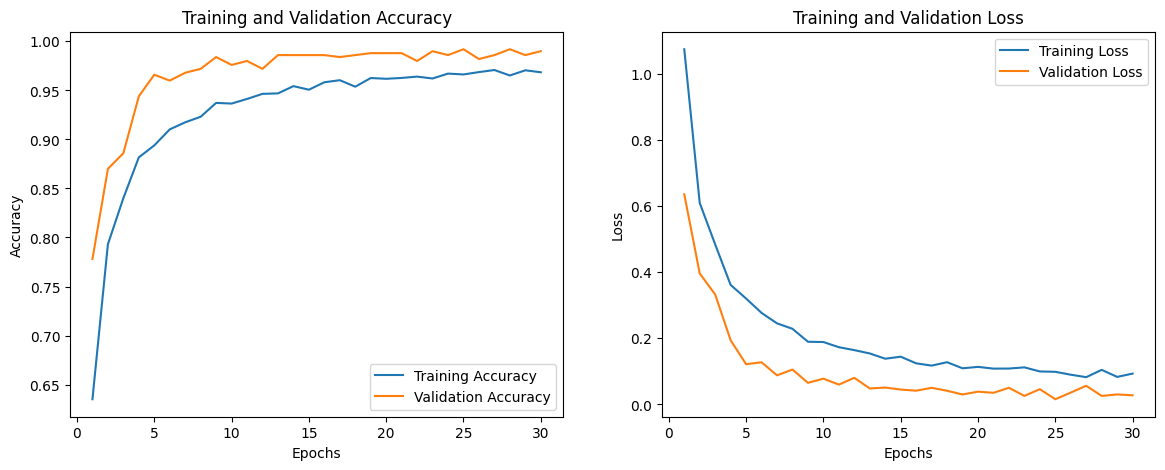

In [52]:
# Call the plot function
plot_training_history(train_acc_hist, val_acc_hist, train_loss_hist, val_loss_hist, num_epochs)
 

## eval

In [53]:
# Evaluate the model on test data
model_ft.eval()
model_ft=model_ft.to(device)
test_corrects = 0
all_preds = []
all_labels = []
# device="cpu"
for inputs, labels in dataloaders['test']:
    inputs = inputs.to(device)
    labels = labels.to(device)
 
    outputs = model_ft(inputs)
    _, preds = torch.max(outputs, 1)
 
    all_preds.extend(preds.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())
    test_corrects += torch.sum(preds == labels.data)
 
test_acc = test_corrects.double() / dataset_sizes['test']
print('Test Accuracy: {:.4f}'.format(test_acc))
 

Test Accuracy: 0.9920


In [54]:
class_names

['bacterial_leaf_blight',
 'bacterial_leaf_streak',
 'bacterial_panicle_blight',
 'blast',
 'brown_spot',
 'dead_heart',
 'downy_mildew',
 'hispa',
 'normal',
 'tungro']

In [55]:
# Generate confusion matrix and classification report
conf_mat = confusion_matrix(all_labels, all_preds)
class_report = classification_report(all_labels, all_preds, target_names=class_names)
print("Confusion Matrix:\n", conf_mat)
print("Classification Report:\n", class_report)

Confusion Matrix:
 [[50  0  0  0  0  0  0  0  0  0]
 [ 0 50  0  0  0  0  0  0  0  0]
 [ 0  0 50  0  0  0  0  0  0  0]
 [ 0  0  0 50  0  0  0  0  0  0]
 [ 0  0  0  0 50  0  0  0  0  0]
 [ 0  0  0  0  0 50  0  0  0  0]
 [ 0  0  0  2  0  0 48  0  0  0]
 [ 0  0  0  1  0  0  0 49  0  0]
 [ 0  0  0  0  0  0  0  1 49  0]
 [ 0  0  0  0  0  0  0  0  0 50]]
Classification Report:
                           precision    recall  f1-score   support

   bacterial_leaf_blight       1.00      1.00      1.00        50
   bacterial_leaf_streak       1.00      1.00      1.00        50
bacterial_panicle_blight       1.00      1.00      1.00        50
                   blast       0.94      1.00      0.97        50
              brown_spot       1.00      1.00      1.00        50
              dead_heart       1.00      1.00      1.00        50
            downy_mildew       1.00      0.96      0.98        50
                   hispa       0.98      0.98      0.98        50
                  normal       

In [56]:
# Convert the labels and predictions to their corresponding class names
actual_class_names = [class_names[label] for label in all_labels]
predicted_class_names = [class_names[pred] for pred in all_preds]

# Create the DataFrame
res = pd.DataFrame({"actual": actual_class_names, "predicted": predicted_class_names})

#res = pd.DataFrame( {"actual": all_labels, "predicted": all_preds})
print(res)
res.to_csv('cura_vt_results.csv', index=False)

                       actual                 predicted
0    bacterial_panicle_blight  bacterial_panicle_blight
1                      tungro                    tungro
2       bacterial_leaf_streak     bacterial_leaf_streak
3                downy_mildew              downy_mildew
4                       blast                     blast
..                        ...                       ...
495     bacterial_leaf_streak     bacterial_leaf_streak
496                    normal                    normal
497                    tungro                    tungro
498                    normal                    normal
499                dead_heart                dead_heart

[500 rows x 2 columns]


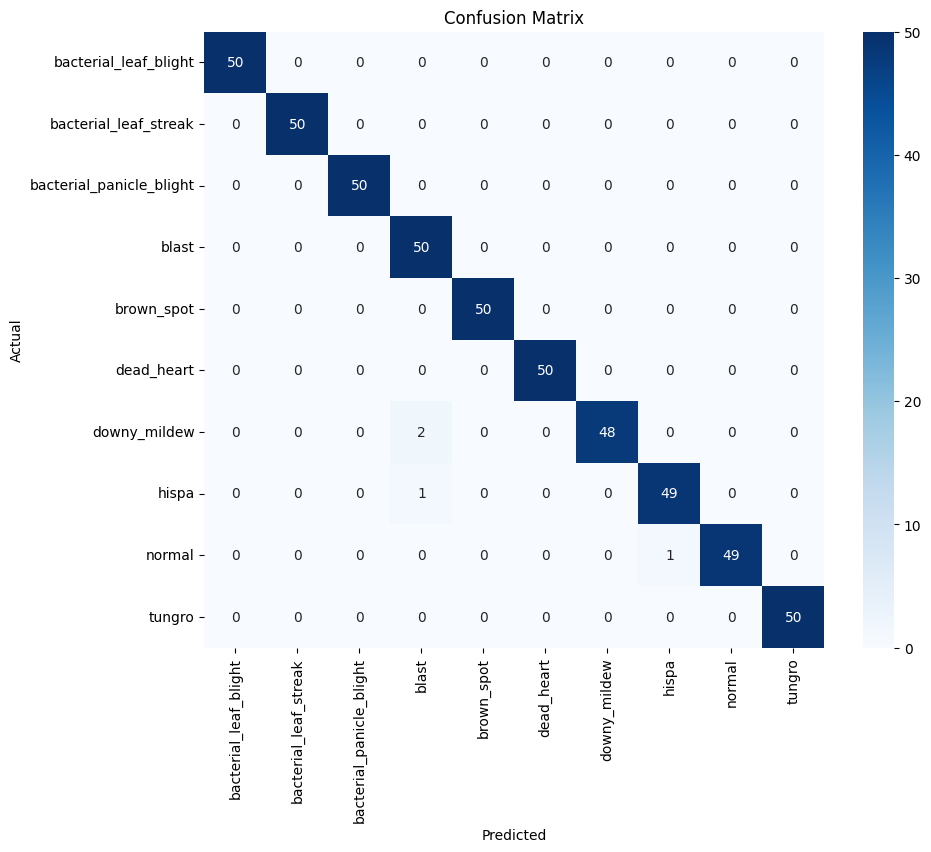

In [57]:
# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.savefig('curat_vt_confusion_matrix.png')
plt.show()


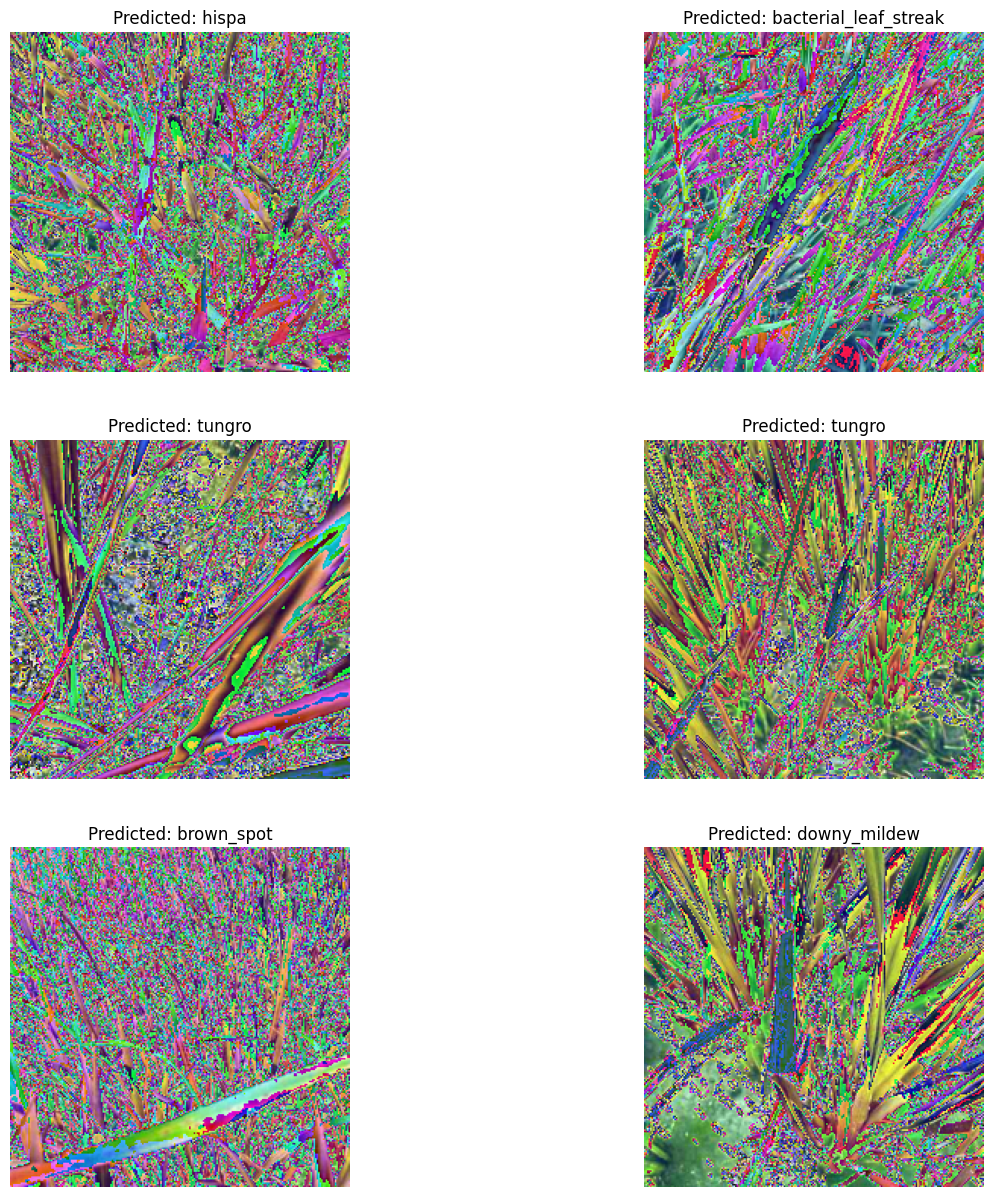

In [58]:

# Function to visualize predictions
def visualize_predictions(model, dataloaders, class_names, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(15, 15))
 
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)
 
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
 
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'Predicted: {class_names[preds[j]]}')
                plt.imshow(F.to_pil_image(inputs.cpu().data[j]))
 
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
 
# Visualize predictions
visualize_predictions(model_ft, dataloaders, class_names, num_images=6)

In [59]:
# Compute and display evaluation metrics
y_true = np.array(all_labels)
y_pred = np.array(all_preds)
 
accuracy = np.mean(y_true == y_pred)
precision = np.diag(conf_mat) / np.sum(conf_mat, axis=0)
recall = np.diag(conf_mat) / np.sum(conf_mat, axis=1)
f1_score = 2 * precision * recall / (precision + recall)
 
print(f"Accuracy: {accuracy:.4f}")

# Calculate and print the average precision, recall, and F1-score
avg_precision = np.mean(precision)
avg_recall = np.mean(recall)
avg_f1_score = np.mean(f1_score)

print(f"Average Precision: {avg_precision:.4f}")
print(f"Average Recall: {avg_recall:.4f}")
print(f"Average F1-Score: {avg_f1_score:.4f}")
 
# Ensure the confusion matrix and the classification report are saved
with open('curat_vt_classification_report.txt', 'w') as f:
    f.write(f"Classification Report:\n{class_report}\n")

Accuracy: 0.9920
Average Precision: 0.9923
Average Recall: 0.9920
Average F1-Score: 0.9920


In [60]:
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=False)


In [61]:
model_ft.load_state_dict(torch.load('nn-vt-org-weights.pth'))

/tmp/ipykernel_1080753/4288144639.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_ft.load_state_dict(torch.load('nn-vt-org-weights.pth'))


<All keys matched successfully>

In [62]:
print(inputs.device) 

cuda:3


In [63]:
# # Load the model
# model_ft.eval()
# model_ft.to(device)
# # Create the attention folder if it doesn't exist
# attention_dir = os.path.join(data_dir, 'attention')
# os.makedirs(attention_dir, exist_ok=True)

# # Iterate through the test dataset
# for inputs, labels in dataloaders['test']:
#     inputs = inputs.to(device)
#     labels = labels.to(device)

#     # Forward pass through the model
#     outputs = model_ft(inputs)

#     # Get the attention map
#     attention_map = model_ft.get_attention_map(inputs)

#     # Save the attention map
#     for i, img in enumerate(inputs):
#         attention_img = F.to_pil_image(attention_map[i])
#         attention_img.save(os.path.join(attention_dir, f'test_image_{i}.png'))
